<a href="https://colab.research.google.com/github/CristiFiodorov/NLP-Clarity/blob/llama-clarity-only/notebooks/03_llama31_8b_alpaca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import os, re, sys
if 'google.colab' in sys.modules:
    import torch; v = re.match(r"[0-9]{1,}\.[0-9]{1,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.33.post1" if v=="2.9" else "0.0.32.post2" if v=="2.8" else "0.0.29.post3")
    %pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    %pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    %pip install --no-deps unsloth
else:
    %pip install unsloth

%pip install transformers==4.56.2
%pip install --no-deps trl==0.22.2

In [3]:
from unsloth import FastLanguageModel
from trl import SFTConfig, SFTTrainer
from pathlib import Path
import sys
from datasets import load_dataset
import pandas as pd
from datasets import Dataset
from tqdm import tqdm
import numpy as np
import torch
import zipfile
from collections import Counter
import time

PLOTS_DIR = Path("models/llama31_8b_lora_clarity/plots")
MODELS_DIR = Path("models/llama31_8b_lora_clarity")
BASE_DRIVE_DIR = Path("/content/drive/MyDrive/NLP-Clarity")

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    MODELS_DIR = BASE_DRIVE_DIR / "models" / "llama31_8b_lora_clarity"
    PLOTS_DIR = MODELS_DIR / "plots"

MODELS_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# === MODEL CONFIG ===
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

# === LOAD MODEL ===
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 16,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

Unsloth 2026.1.2 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


In [6]:
DATA_DIR = Path("data")

if 'google.colab' in sys.modules:
    DATA_DIR = BASE_DRIVE_DIR / "data"

train_path = DATA_DIR / "train_cleaned.csv"
val_path = DATA_DIR / "val.csv"


# - The 'test' split on HuggingFace (308 samples) IS the public leaderboard set.
# - We treat this as our VALIDATION set ('df_val') to select the best model.
# - We also save the train and val to disk, in case dataset from huggingface is updated (e.g., when evaluation phase will start).
def load_qevasion_dataset():
    if train_path.exists() and val_path.exists():
        df_train = pd.read_csv(train_path)
        df_val = pd.read_csv(val_path)
        return df_train, df_val
    else:
        dataset = load_dataset("ailsntua/QEvasion")
        df_train = dataset["train"].to_pandas()
        df_val = dataset["test"].to_pandas()
        df_train.to_csv(train_path, index=False)
        df_val.to_csv(val_path, index=False)
        return df_train, df_val

df_train, df_val = load_qevasion_dataset()

In [7]:
INSTRUCTION = """You are an expert in political discourse analysis. Analyze the following question-answer pair from a political interview and classify the clarity of the responses.

Context: You will receive an interviewer question, a sub-question, and an answer. The sub-question represents a summary of one of the potentially multiple questions asked by the interviewer, but the answer is the full response. Focus only on the portion of the answer relevant to the sub-question.

The taxonomy of responses consists of 3 main clarity levels, which can have each of the following definitions:

1. Clear Reply (Unambiguous)
   - The information requested is explicitly stated (in the requested form)

2. Ambivalent Reply
   - The information requested is given, but without being explicitly stated (not in the expected form)
   - The information provided is too general/lacks the requested specificity
   - Offers only a specific component of the requested information
   - Ignoring the question altogether
   - Starts on topic but shifts focus and makes a different point than asked

3. Clear Non-Reply
   - Acknowledge the question but directly or indirectly refusing to answer at the moment
   - The answerer claims/admits not to know the answer themselves
   - Does not provide the requested information and asks for clarification

Task: Output ONLY ONE of the specific clarity labels for that specific sub-question ('Clear Reply', 'Ambivalent Reply', 'Clear Non-Reply')."""

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

In [8]:
def formatting_prompts_func(examples):
    full_questions = examples["interview_question"]
    questions = examples["question"]
    answers = examples["interview_answer"]
    labels = examples["clarity_label"]

    texts = []
    for full_question, question, answer, label in zip(full_questions, questions, answers, labels):
        input_text = f"Interview Question(s): {full_question}\nSub-question: {question}\nAnswer: {answer}"
        text = alpaca_prompt.format(INSTRUCTION, input_text, label) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.map(formatting_prompts_func, batched=True)

Map:   0%|          | 0/3403 [00:00<?, ? examples/s]

In [9]:
train_dataset[:1]

{'Unnamed: 0': [0],
 'title': ["The President's News Conference in Hanoi, Vietnam"],
 'date': ['September 10, 2023'],
 'president': ['Joseph R. Biden'],
 'url': ['https://www.presidency.ucsb.edu/documents/the-presidents-news-conference-hanoi-vietnam-0'],
 'question_order': [1],
 'interview_question': ['Q. Of the Biden administration. And accused the United States of containing China while pushing for diplomatic talks.How would you respond to that? And do you think President Xi is being sincere about getting the relationship back on track as he bans Apple in China?'],
 'interview_answer': ["Well, look, first of all, theI am sincere about getting the relationship right. And one of the things that is going on now is, China is beginning to change some of the rules of the game, in terms of trade and other issues.And so one of the things we talked about, for example, is that they're now talking about making sure that no Chineseno one in the Chinese Government can use a Western cell phone. Th

In [10]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

def print_training_stats(trainer_stats):
    used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
    used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
    used_percentage = round(used_memory / max_memory * 100, 3)
    lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
    print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
    print(
        f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
    )
    print(f"Peak reserved memory = {used_memory} GB.")
    print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
    print(f"Peak reserved memory % of max memory = {used_percentage} %.")
    print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
7.135 GB of memory reserved.


In [12]:
# f1_for_class modified version
def f1_for_class(labels, predictions, target_class):
    """
    Calculates Precision/Recall/F1 for only one class.

    gold_annotations: list of lists (or sets) with labels per sample
    predictions: list with one prediction per sample
    target_class: the class for which we want the F1
    """
    TP = FP = FN = 0

    for label, pred in zip(labels, predictions):
        if pred == target_class and target_class == label:
            TP += 1  # we correctly predicted target_class
        elif pred == target_class and target_class != label:
            FP += 1  # we predicted target_class but it was not in gold
        elif target_class == label and pred != label:
            FN += 1  # the class was in gold but the sample is overall wrong

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return {"precision": precision, "recall": recall, "f1": f1, "tp": TP, "fp": FP, "fn": FN}


def compute_macro_f1(labels, predictions):
    """
    Compute Macro-F1 score (same as CodaBench leaderboard).

    Args:
        gold_annotations: list of lists - each inner list contains valid labels from annotators
        predictions: list of strings - one prediction per sample

    Returns:
        float: Macro F1 score
    """
    all_classes = set()
    for label in labels:
        all_classes.add(label)
    classes = sorted(list(all_classes))

    f1_scores = []
    for cls in classes:
        result = f1_for_class(labels, predictions, cls)
        f1_scores.append(result["f1"])

    macro_f1 = float(np.mean(f1_scores))

    return macro_f1

In [13]:
def predict_clarity_labels(model, tokenizer, df):
    FastLanguageModel.for_inference(model)

    predictions = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Predicting"):
        input_text = f"Question: {row['question']}\nAnswer: {row['interview_answer']}"
        prompt = alpaca_prompt.format(INSTRUCTION, input_text, "")

        inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
        outputs = model.generate(**inputs, max_new_tokens=20, use_cache=True)
        response = tokenizer.decode(outputs[0], skip_special_tokens=True)

        if "### Response:" in response:
            pred_label = response.split("### Response:")[-1].strip()
        else:
            pred_label = response.strip()

        pred_label = pred_label.split("\n")[0].strip()
        predictions.append(pred_label)

    return predictions

def evaluate_model(model, tokenizer, df_val):
    predictions = predict_clarity_labels(model, tokenizer, df_val)
    labels = df_val['clarity_label'].values.tolist()
    macro_f1 = compute_macro_f1(labels, predictions)
    return macro_f1

In [14]:
import json
from datetime import datetime

RESULTS_LOG_PATH = MODELS_DIR / "experiment_log.json"
BEST_SCORE_PATH = MODELS_DIR / "best_score.json"


def log_experiment(config, macro_f1):
    """Append experiment to log file."""
    if RESULTS_LOG_PATH.exists():
        with open(RESULTS_LOG_PATH, 'r') as f:
            experiment_log = json.load(f)
    else:
        experiment_log = []

    experiment_log.append({
        "timestamp": datetime.now().isoformat(),
        "config": config,
        "train_data": str(train_path),
        "macro_f1": macro_f1,
        "plot_path": str(plot_path)
    })

    with open(RESULTS_LOG_PATH, 'w') as f:
        json.dump(experiment_log, f, indent=2)


def save_if_best(model, tokenizer, config, macro_f1):
    """Save LoRA model if it beats current best. Returns True if saved."""
    if BEST_SCORE_PATH.exists():
        with open(BEST_SCORE_PATH, 'r') as f:
            best_f1 = json.load(f).get("macro_f1", 0)
    else:
        best_f1 = 0

    if macro_f1 > best_f1:
        with open(BEST_SCORE_PATH, 'w') as f:
            json.dump({
                "timestamp": datetime.now().isoformat(),
                "config": config,
                "macro_f1": macro_f1,
                "train_data": str(train_path),
                "plot_path": str(plot_path)
            }, f, indent=2)

        model.save_pretrained(MODELS_DIR / "best_lora")
        tokenizer.save_pretrained(MODELS_DIR / "best_lora")

        print(f"New Best! F1: {macro_f1:.4f} (prev: {best_f1:.4f})")
        return True

    return False

**Use this cell to train models, track experiments, and save the best performing one.**

This pipeline will:
1. **Train Llama 3.1 8B** with LoRA adapters using the specified configuration.
2. **Evaluate** performance on the validation set using the official Macro-F1 metric.
3. **Log** every experiment to `experiment_log.json` (so you don't lose history).
4. **Auto-Save Best Model**: If the current model beats the previous best F1 score, it automatically saves LoRA adapters to `best_lora/`.

**How to use:**
- Change the `config` dictionary below.
- Run the cell.

In [15]:
from transformers import TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from IPython.display import clear_output
import matplotlib.pyplot as plt

class CustomEvalCallback(TrainerCallback):
    def __init__(self, model, tokenizer, df_val, eval_function, output_file="training_progress.png"):
        self.model = model
        self.tokenizer = tokenizer
        self.df_val = df_val
        self.eval_function = eval_function

        self.output_file = output_file

        self.epoch_history = []
        self.train_loss_history = []
        self.train_loss_on_epoch = []
        self.val_f1_history = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.train_loss_history.append(logs['loss'])

    def on_epoch_end(self, args: TrainingArguments, state: TrainerState, control: TrainerControl, **kwargs):
        print(f"\n=== End of Epoch {state.epoch} - Running Custom Evaluation ===")

        self.model.eval()

        macro_f1 = self.eval_function(self.model, self.tokenizer, self.df_val)

        print(f"Macro F1 on validation set after this epoch: {macro_f1}")

        self.model.train()

        self.val_f1_history.append(macro_f1)
        self.epoch_history.append(state.epoch)
        self.train_loss_on_epoch.append(self.train_loss_history[-1])

    def on_train_end(self, args, state, control, **kwargs):
        """
        Triggered automatically when trainer.train() finishes.
        Saves the final plot to disk.
        """
        print(f"\nTraining Finished. Saving final plot to {self.output_file}...")
        self.plot_metrics(save=True)

    def plot_metrics(self, save=False):
        fig, ax1 = plt.subplots(1, 2, figsize=(15, 5))

        if self.train_loss_history:
            ax1[0].plot(self.train_loss_history, label='Training Loss', color='orange')
            ax1[0].set_title('Training Loss Curve (Per Step)')
            ax1[0].set_xlabel('Logging Steps')
            ax1[0].set_ylabel('Loss')
            ax1[0].legend()
            ax1[0].grid(True, alpha=0.3)
        else:
            ax1[0].text(0.5, 0.5, 'No Loss Data Yet\n(Check logging_steps)',
                        ha='center', va='center')

        if self.epoch_history:
            ax1[1].plot(self.epoch_history, self.val_f1_history, label='Val F1 (Macro)', marker='o', color='blue')

            latest_f1 = self.val_f1_history[-1]
            ax1[1].annotate(f'{latest_f1:.3f}',
                           (self.epoch_history[-1], latest_f1),
                           textcoords="offset points",
                           xytext=(0,10),
                           ha='center')

            ax1[1].set_title('Validation Performance')
            ax1[1].set_xlabel('Epochs')
            ax1[1].set_ylabel('Score')
            ax1[1].set_ylim(0, 1.0)
            ax1[1].legend()
            ax1[1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save:
            plt.savefig(self.output_file, dpi=150)

        plt.show()

        print(f"Validation history: {self.val_f1_history}")

In [16]:
def run_experiment(config):
    trainer = SFTTrainer(
        model = model,
        tokenizer = tokenizer,
        train_dataset = train_dataset,
        dataset_text_field = "text",
        max_seq_length = max_seq_length,
        packing = False,
        args = SFTConfig(
            per_device_train_batch_size = config.get("batch_size", 2),
            gradient_accumulation_steps = config.get("grad_accum", 4),
            warmup_steps = config.get("warmup_steps", 5),
            num_train_epochs = config["epochs"],
            learning_rate = config["learning_rate"],
            logging_steps = 1,
            optim = "adamw_8bit",
            weight_decay = config.get("weight_decay", 0.001),
            lr_scheduler_type = "linear",
            seed = 3407,
            output_dir = str(MODELS_DIR / "checkpoints"),
            report_to = "none",
        ),
        callbacks = [validation_callback],
    )

    trainer_stats = trainer.train()
    print_training_stats(trainer_stats)

    macro_f1 = evaluate_model(model, tokenizer, df_val)

    log_experiment(config, macro_f1)
    save_if_best(model, tokenizer, config, macro_f1)

    return macro_f1, trainer_stats


In [17]:
plot_path = str(PLOTS_DIR / f"training_progress_{int(time.time())}.png")

validation_callback = CustomEvalCallback(
    model=model,
    tokenizer=tokenizer,
    df_val=df_val,
    eval_function=evaluate_model,
    output_file = plot_path
)

In [ ]:
plot_path

'/content/drive/MyDrive/NLP-Clarity/models/llama31_8b_lora/plots/training_progress_1768347232.png'

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/3403 [00:00<?, ? examples/s]

🦥 Unsloth: Padding-free auto-enabled, enabling faster training.


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,403 | Num Epochs = 1 | Total steps = 213
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 8
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 8 x 1) = 16
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,2.408100
2,2.378500
3,2.445300
4,2.409100
5,2.296600
6,2.115900
7,1.971000
8,2.020800
9,1.763000
10,1.708700



=== End of Epoch 1.0 - Running Custom Evaluation ===


Predicting: 100%|██████████| 308/308 [01:37<00:00,  3.17it/s]


Macro F1 on validation set after this epoch: 0.3414813140465296

Training Finished. Saving final plot to /content/drive/MyDrive/NLP-Clarity/models/llama31_8b_lora_clarity/plots/training_progress_1768351073.png...


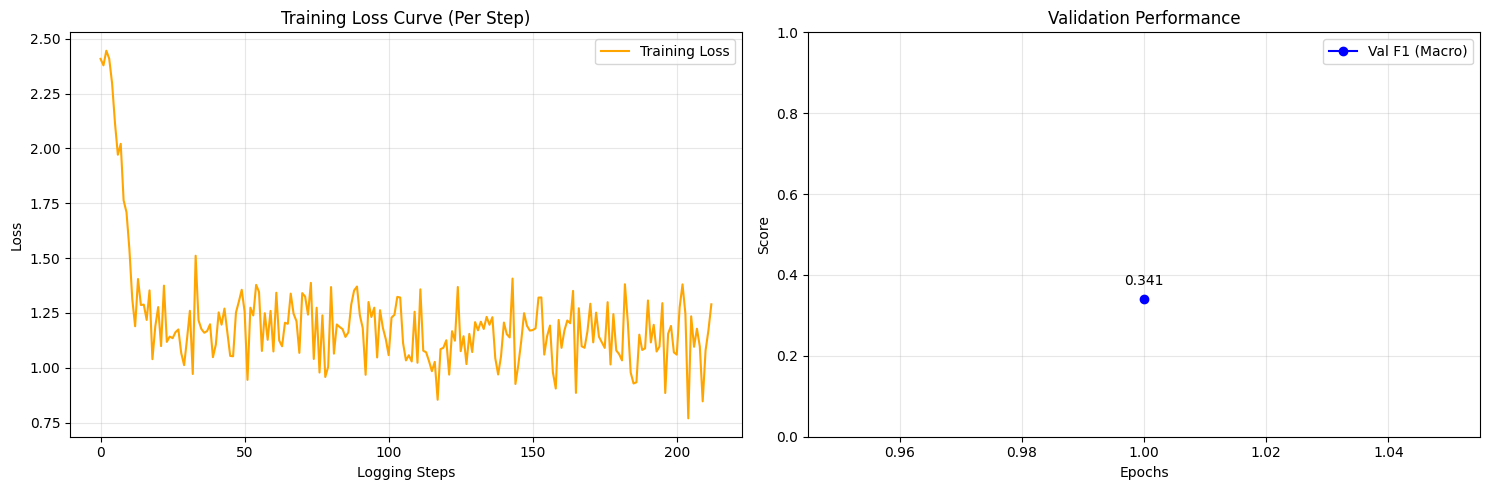

Validation history: [0.3414813140465296]
1153.9248 seconds used for training.
19.23 minutes used for training.
Peak reserved memory = 8.361 GB.
Peak reserved memory for training = 1.226 GB.
Peak reserved memory % of max memory = 21.137 %.
Peak reserved memory for training % of max memory = 3.099 %.


Predicting: 100%|██████████| 308/308 [01:35<00:00,  3.23it/s]


New Best! F1: 0.4577 (prev: 0.0000)


In [18]:
config = {
    "model": "Llama-3.1-8B",
    "adapter": "LoRA",
    "r": 16,
    "epochs": 1,
    "learning_rate": 2e-4,
    "instruction": INSTRUCTION,
    "batch_size": 2,
    "grad_accum": 8,
}

macro_f1, stats = run_experiment(config)

In [ ]:
model

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(128256, 4096, padding_idx=128004)
        (layers): ModuleList(
          (0): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Identity()
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=16, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k_proj): lora.Linear

Run this cell ONLY to generate submission files for CodaBench.

This pipeline will:
1. Load your **best saved LoRA model** (`best_lora/`) from the models directory.
2. Download the **"test" dataset** from HuggingFace.
3. Generate predictions for both:
   - **Task 2 (Evasion)**: Direct predictions from the model (9 labels).
   - **Task 1 (Clarity)**: Derived by mapping evasion labels to clarity categories (3 labels).
4. Save formatted `.zip` files ready for upload to CodaBench.

In [19]:
# EVASION_TO_CLARITY = {
#     'Explicit': 'Clear Reply',
#     'Implicit': 'Ambivalent',
#     'Dodging': 'Ambivalent',
#     'General': 'Ambivalent',
#     'Deflection': 'Ambivalent',
#     'Partial/half-answer': 'Ambivalent',
#     'Declining to answer': 'Clear Non-Reply',
#     'Claims ignorance': 'Clear Non-Reply',
#     'Clarification': 'Clear Non-Reply',
# }

SUBMISSIONS_DIR = MODELS_DIR / "submissions"


def load_best_model():
    """Load best LoRA model from disk."""
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = str(MODELS_DIR / "best_lora"),
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model)
    return model, tokenizer


def load_test_data():
    """Download fresh test data from HuggingFace."""
    dataset = load_dataset("ailsntua/QEvasion")
    return dataset["test"].to_pandas()


# def evasion_to_clarity(y_evasion):
#     """Map evasion labels to clarity labels."""
#     return [EVASION_TO_CLARITY[e] for e in y_evasion]


def save_submission(predictions, task_name):
    """Save predictions as a properly formatted zip for CodaBench."""
    SUBMISSIONS_DIR.mkdir(parents=True, exist_ok=True)

    pred_path = SUBMISSIONS_DIR / f"prediction_{task_name}"
    zip_path = SUBMISSIONS_DIR / f"submission_{task_name}.zip"

    with open(pred_path, 'w') as f:
        f.write('\n'.join(predictions))

    with zipfile.ZipFile(zip_path, 'w') as zf:
        zf.write(pred_path, "prediction")

    return zip_path


def generate_submissions():
    """Full pipeline: load model → predict → save submissions."""
    best_model, best_tokenizer = load_best_model()

    df_test = load_test_data()

    y_clarity = predict_clarity_labels(best_model, best_tokenizer, df_test)
    # y_clarity = evasion_to_clarity(y_evasion)

    # zip_task2 = save_submission(y_evasion, "task2")
    zip_task1 = save_submission(y_clarity, "task1")

    return {
        "task1_zip": zip_task1,
        # "task2_zip": zip_task2,
        # "evasion_dist": Counter(y_evasion),
        "clarity_dist": Counter(y_clarity),
    }

results = generate_submissions()
results

==((====))==  Unsloth 2026.1.2: Fast Llama patching. Transformers: 4.56.2.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/3.90M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/259k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3448 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/308 [00:00<?, ? examples/s]

Predicting: 100%|██████████| 308/308 [01:32<00:00,  3.32it/s]


{'task1_zip': PosixPath('/content/drive/MyDrive/NLP-Clarity/models/llama31_8b_lora_clarity/submissions/submission_task1.zip'),
 'clarity_dist': Counter({'Clear Reply': 100,
          'Clear Non-Reply': 8,
          'Ambivalent': 189,
          'Thank you.': 1,
          "Okay, Mark. You know, we're working with Congress to get the money to fund the leve": 1,
          'Freedom is a powerful weapon. And I would like to thank the— all the allies that are contributing': 1,
          'Yes.': 1,
          'Yes, Jim.': 1,
          'We are, Richard. Thank you. Thanks for asking the question. They were asking me about somebody': 1,
          'Toby [Tabassum Zakaria, Reuters]. Last question?': 1,
          "I think you've got to wait and see. I'm going to wait and see what General Petra": 1,
          'Mark Silva [Chicago Tribune].': 1,
          "I think the voters have spoken. They've made a choice. I think that the country is ready": 1,
          "I'm not disappointed, because I'm the one w